In [1]:
import generate_visual_bars_data as vbd

from cluster_methods import kmeans
from density_estimation_methods import condExp
import tensorflow as tf

import core_cfl_objects.two_step_cfl as tscfl

In [2]:
# generate visual bars data 
n_samples = 1000
im_shape = (10, 10)
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=0)

x = vb_data.getImages()
y = vb_data.getTarget()


#reformat x, y into the right shape for the neural net 
import numpy as np 
y = np.expand_dims(y, -1)
x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2])) 


In [4]:
# parameters for CDE 
optimizer_Adam = tf.keras.optimizers.Adam(lr=1e-3)
condExp_params = {'batch_size': 128, 'lr': 1e-3, 'optimizer': optimizer_Adam, 'n_epochs': 200, 'test_every': 10, 'save_every': 10}
data_info = {'X_dims': x.shape, 'Y_dims': y.shape} #NOTE: I was a little confused here about how to enter the dimensions until I realized to just get the shape from the np function 

# generate CDE object
condExp_object = condExp.CondExp(data_info, condExp_params, True)



In [5]:
# generate clusterer 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':4}
cluster_object = kmeans.KMeans(cluster_params)


# put into a cfl core object 
cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn_input_layer (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
nn_dropout1 (Dropout)        (None, 100)               0         
_________________________________________________________________
nn_dense1 (Dense)            (None, 50)                5050      
_________________________________________________________________
nn_dropout2 (Dropout)        (None, 50)                0         
_________________________________________________________________
nn_layer2 (Dense)            (None, 10)                510       
_________________________________________________________________
nn_dropout3 (Dropout)        (None, 10)                0         
_________________________________________________________________
nn_output_layer (Dense)      (None, 1)                 11    

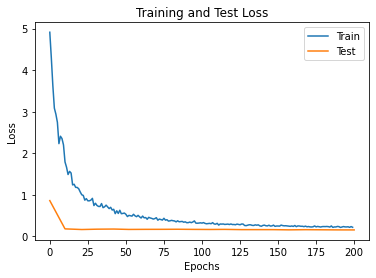

100%|██████████| 1000/1000 [00:00<00:00, 2397.14it/s]


In [6]:
x_lbls, y_lbls = cfl_object.train(x, y)

# and then run visual bars through that 
# see what we get 

In [9]:
# check the results of CFL against the original 
accuracy = (x_lbls == vb_data.getGroundTruth())
print("percent correct: ", np.sum(accuracy)/len(accuracy))

percent correct:  0.316


In [8]:
# thoughts: 
# - currently, we have to reshap e
# - it gave y-labels, which we didn't want (they're kind of meaningless in this case? raise a warning to prevent people from doing? )
# - I think we should raise a warning or something if the CDE gets trained twice - cause otherwise you could get confusing graphs from the training/test loss
# the tqdm bar is great, but you can't tell it's referring to the clustering - we should add a print statement ahead of it 